In [1]:
import simsz.get_dm_halo as get_dm_halo
import simsz.utils as utils
import make_sz_cluster
import simsz.read_yaml as read_yaml
import simsz.load_vars as load_vars
from colossus.halo import mass_adv

import time
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import h5py
from pixell import enmap, powspec, enplot
import camb

from astropy.constants import M_sun
from astropy.constants import G, sigma_T, m_e, c, h, k_B
from astropy import units as u

What this notebook currently does: 
- Reads in data from the sim run yaml
- Loads cosmology
- Generates and saves a flat redshift and Mvir distribution as a .txt file
- Loads an existing redshift and Mvir distribution from a .txt file

What this notebook could do, but currently doesn't:
- Generate/use M200 rather than convert from Mvir
- Save m, z dist as .h
- Generates a realistic z, M500 distribution from a given cosmology 

What the modules could be improved to do:
- Streamline the generation of z,M500 distributions by creating a function with options
- Save the z, M500 distribution at the function level in GenerateHalo.py

Problems to be addressed:
- Profile is oddly steep and needs to be checked with Battaglia 2012 realistic z,M, params

In [2]:
ref=read_yaml.YAMLOperator('./simsz/Settings/inputdata.yaml').parse_yaml() #Read in the .yaml for this simulation run 

In [3]:
(survey,survey_freq,beam_size,noise_level,image_size,pixel_scale)=load_vars.load_vars().make_dict(ref) #Make a dictionary from the .yaml

In [4]:
(cosmo,sigma8,ns)=load_vars.load_vars().flatLCDM(ref) #Make cosmology from yaml input parameters 

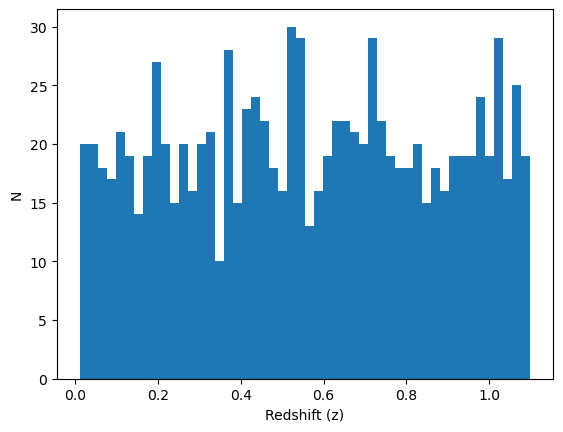

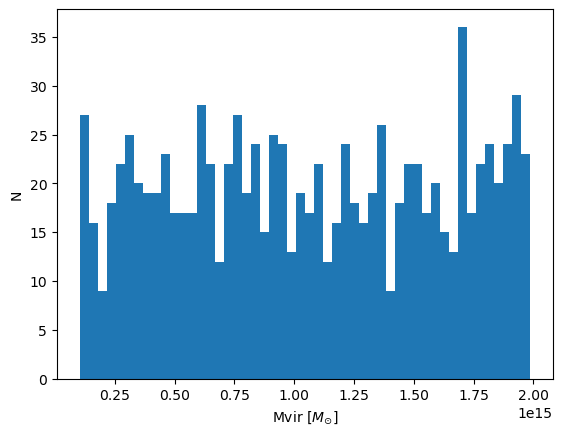

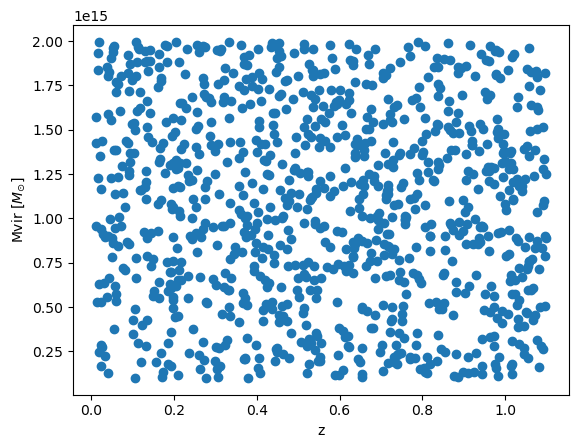

In [5]:
#Generate a new flat z, Mvir distribution and save to file: 
halo=get_dm_halo.GenerateHalo() #Load in get_dm_halo class
szcluster=make_sz_cluster.GenerateCluster() #Load in make_sz_cluster class
nsources=1000 #Number of halos to generate
zdist,mdist=halo.flatdist_halo(0.01,1.1,1e14,2e15,nsources) #Generate a flat z, Mvir distribution for sims

plt.hist(zdist,bins=50) #Show the z distribution 
plt.ylabel('N'),plt.xlabel('Redshift (z)')
plt.show()
plt.hist(mdist,bins=50) #Show the M500 distribution 
plt.ylabel('N'),plt.xlabel(r'Mvir [$M_{\odot}$]')
plt.show()
plt.plot(zdist,mdist,'o') #Show the z, M500 scatterplot
plt.xlabel('z'),plt.ylabel(r'Mvir [$M_{\odot}$]')
plt.show()

sourceid=int(time.time()) #Create an initial ctime for the halo ID list to save catalog
idlist=[sourceid+x for x in range(len(zdist))] #Create the halo ID list for catalog

np.savetxt('flatmassdist.csv',np.array([zdist,mdist,idlist]).T,delimiter=',') #Save this array to txt

In [6]:
#Load an existing z, M array from txt file
d=np.loadtxt('flatmassdist.csv',delimiter=',') 
zdist=d[:,0]
mdist=d[:,1]
idlist=d[:,2]

In [7]:
r=np.linspace(0.01,10,10000) #arcmin
r=utils.arcmin_to_Mpc(r,0.5,cosmo)

In [8]:
z=0.48
M200=194038855760143.47 #solar masses

In [9]:
(M200,R200,c200)=szcluster.m200_to_r200(cosmo,sigma8,ns,M200,z) #Use M200 to get R200 and concentration from Colossus

In [10]:
P200 = szcluster.P200_Battaglia2012(cosmo,z,M200,R200) #P200 from Battaglia et al. 2012

In [11]:
P0=szcluster.param_Battaglia2012(18.1,0.154,-0.758,M200,z) #Parameter computation from Table 1 Battaglia et al. 2012
xc=szcluster.param_Battaglia2012(0.497,-0.00865,0.731,M200,z)
beta=szcluster.param_Battaglia2012(4.35,0.0393,0.415,M200,z)

In [12]:
Pth=szcluster.Pth_Battaglia2012(r,R200,-0.3,1.0,beta,xc,P0) #Output Battaglia 2012 pressure profile

In [13]:
Pth_rescaled=(Pth)*(r/R200)**3.

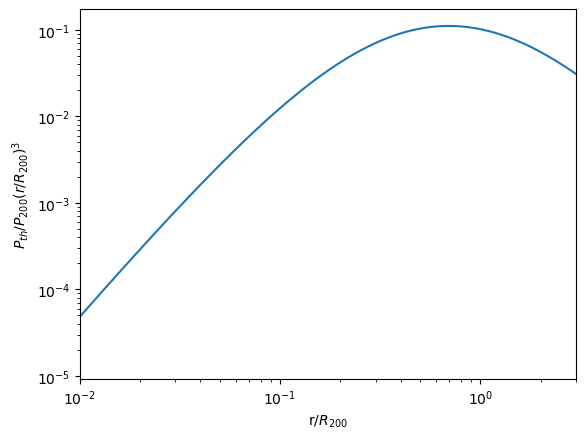

In [14]:
plt.plot(r/R200,Pth_rescaled) #Plot Battaglia 2012 pressure profile
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$P_{th}/P_{200}(r/R_{200})^3$')
plt.xlabel('r/$R_{200}$')
plt.xlim(.010,3)
plt.show()

In [15]:
y = szcluster.epp_to_y(szcluster.Pth_Battaglia2012, r, R200=R200, gamma=-0.3,alpha=1.0,beta=beta,xc=xc,P0=P0, P200=P200)

In [16]:
y[0] #print central y value

2.0780683210418443e-05

In [17]:
fSZ=szcluster.f_sz(150,cosmo.Tcmb0) #get f_SZ for observation frequency of 30 GHz
dT=cosmo.Tcmb0*y[0]*fSZ #get dT from y0 using f_SZ
dT=dT.to(u.uK) #Convert to uK
print(dT)

-53.964653405080604 uK


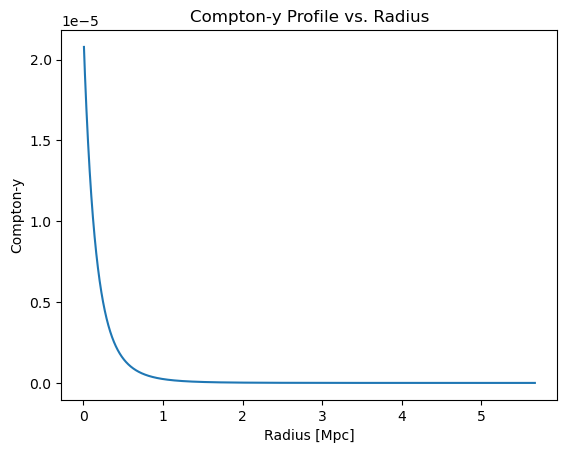

In [18]:
plt.plot(r, y)
plt.xlabel('Radius [Mpc]')
plt.ylabel('Compton-y')
plt.title('Compton-y Profile vs. Radius')

plt.show()

max:  2.1512690081682264e-05


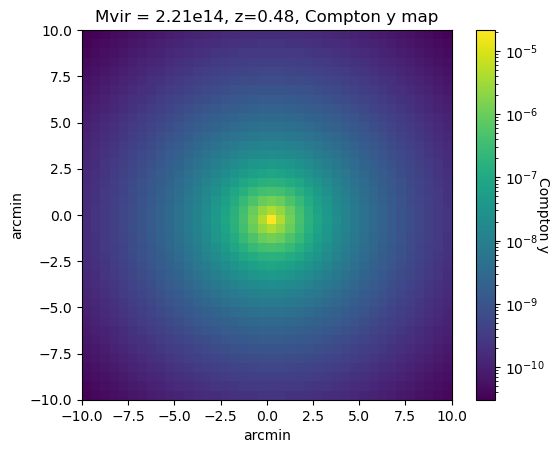

In [19]:
width = 10
pix_size = 0.5
y_map = szcluster.make_y_submap(szcluster.Pth_Battaglia2012, z, cosmo, width, pix_size, R200=R200, gamma=-0.3,alpha=1.0,beta=beta,xc=xc,P0=P0, P200=P200)
im = plt.imshow(y_map, norm=LogNorm())
cbar = plt.colorbar(im)
im.set_extent([-width,width,-width,width])
plt.title('Mvir = 2.21e14, z=0.48, Compton y map')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('Compton y', rotation=270)
print('max: ', y_map.max())

In [20]:
def generate_noise_map(N, noise_level, pix_size):
    """
    Generates a noise map based on the noise level and beam size.

    Args:
        N (int): Size of the noise map (N x N).
        noise_level (float): Noise level of the survey.

    Returns:
        ndarray: Noise map.
    """
    pix_scale = ref['IMAGES']['pixel_scale']
    
    # Create random noise map
    random_noise_map = np.random.normal(0, 1, (N, N))

    # Scale random noise map by noise level
    scaled_noise_map = random_noise_map * noise_level
    noise_map = scaled_noise_map / pix_size

    return noise_map

In [21]:
N =41
noise_level = ref['SURVEYS']['ACTDR5'][150]['noise_level']
pix_scale = ref['IMAGES']['pixel_scale']


max:  55.86557729184121 uK


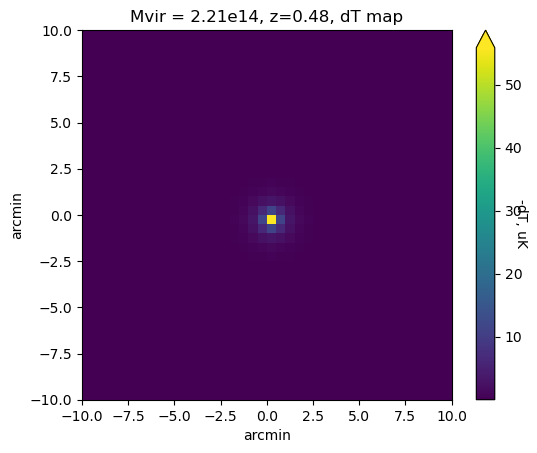

In [22]:
dT_map = (y_map * cosmo.Tcmb0 * -fSZ).to(u.uK)
#noise_map=generate_noise_map(N, 1) * u.uK
im = plt.imshow(dT_map,)
cbar = plt.colorbar(im, extend="max")
im.set_extent([-width,width,-width,width])
plt.title('Mvir = 2.21e14, z=0.48, dT map')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('-dT, uK', rotation=270)
print("max: ", dT_map.max())

max:  153.78365914904765 uK
min:  7.639046090051051 uK


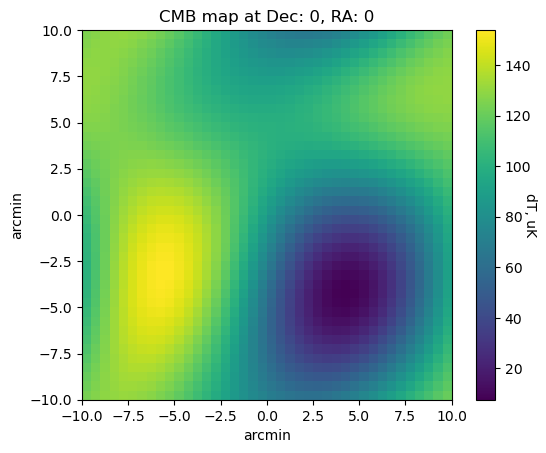

In [23]:
ps = szcluster.get_cls(ns=ns, cosmo=cosmo)
cmb_map = szcluster.make_cmb_map(shape=y_map.shape, pix_size=pix_size, ps=ps)*u.uK
im = plt.imshow(cmb_map)
cbar = plt.colorbar(im)
im.set_extent([-width,width,-width,width])
plt.title('CMB map at Dec: 0, RA: 0')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('dT, uK', rotation=270)
# This is in units of positive uK
print("max: ", cmb_map.max())
print("min: ", cmb_map.min())

NameError: name 'total_map' is not defined

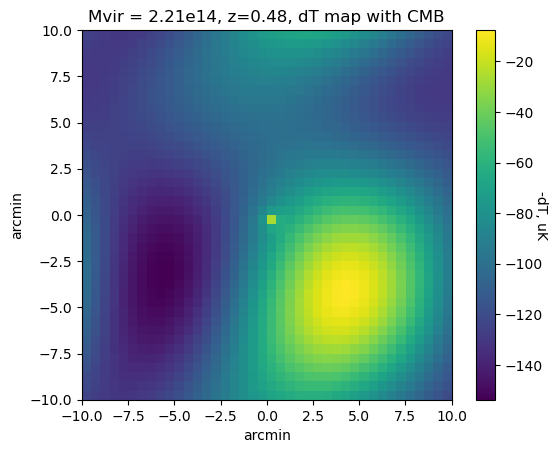

In [24]:
signal_map = dT_map - cmb_map # -(fSZ * y + CMB) 
im = plt.imshow(signal_map)
cbar = plt.colorbar(im)
im.set_extent([-width,width,-width,width])
plt.title('Mvir = 2.21e14, z=0.48, dT map with CMB')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('-dT, uK', rotation=270)
#This is in units of -uK, to match with the original dT map
print("max: ", signal_map.max())

max:  -64.00632400130657


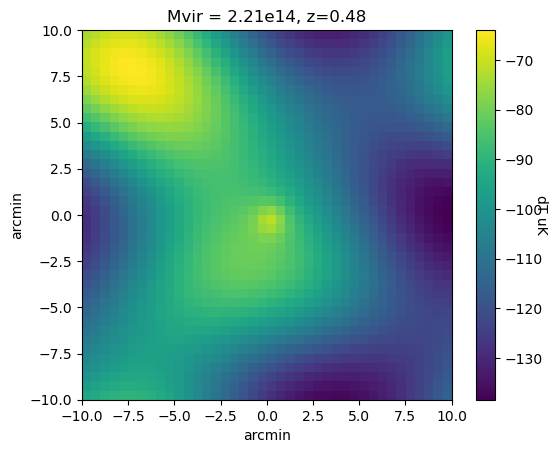

In [25]:
beam_size_fwhp = 1.25
conv_map = conv_map = szcluster.add_cmb_map_and_convolve(dT_map, ps, pix_size, beam_size_fwhp)
im = plt.imshow(conv_map)
cbar = plt.colorbar(im)
im.set_extent([-width,width,-width,width])
plt.title('Mvir = 2.21e14, z=0.48')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('dT uK', rotation=270)
print('max: ', conv_map.max())

max:  55.86557729184121 uK


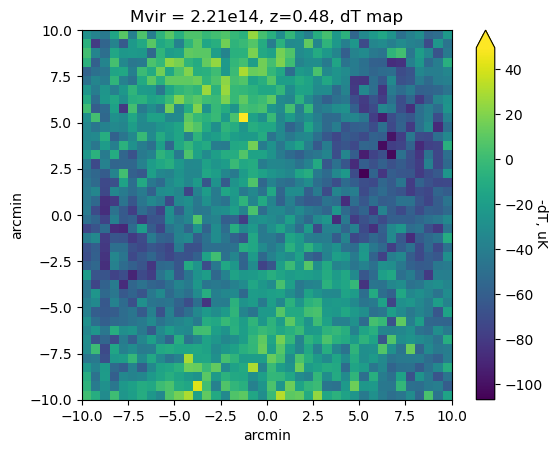

In [26]:
noise_map=generate_noise_map(N, 3, pix_size)
total_map=conv_map - noise_map
im = plt.imshow(total_map)
cbar = plt.colorbar(im, extend="max")
im.set_extent([-width,width,-width,width])
plt.title('Mvir = 2.21e14, z=0.48, dT map')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('-dT, uK', rotation=270)
print("max: ", dT_map.max())

In [27]:
noise_level

30

In [28]:
sim_id = 0
# Data to be stored:
data = {
'temperature_submap': dT_map,
'noise_submap' : np.zeros((10,10)),
'cmb_submap' : cmb_map,
'y_central' : y_map[width][width],
'M200': M200,
'redshift_z': z,
'concentration': c200,
'ID': sim_id,
}
with h5py.File('sz_sim_data.h5', 'a') as f:
    utils.save_sim_to_h5(f, f"sim_{sim_id}", data, overwrite=True)

Average in inner radius: -33.000482408494506
Average in outer radius: -30.09473632074932
tSZ signal: -2.905746087745186


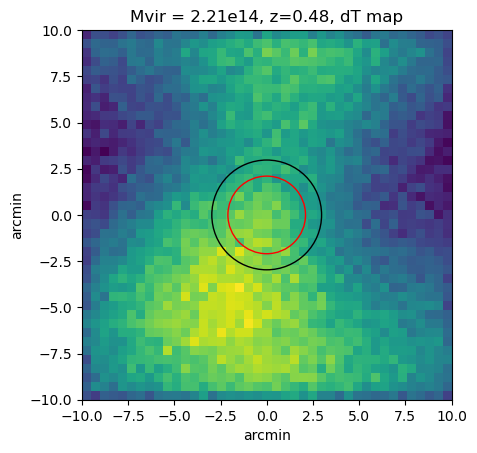

In [29]:
disk, ring, signal = szcluster.get_tSZ_signal(total_map, 2.1)
print('Average in inner radius: '+str(disk))
print('Average in outer radius: '+str(ring))
print('tSZ signal: '+str(signal))
center = np.array(total_map.shape) / 2
center = center - center[0]
fig, ax = plt.subplots()
ax.imshow(total_map, extent=[-width,width,-width,width])
disk_circle = plt.Circle(center, 2.1, color='red', fill=False, linewidth=1)
annulus_circle = plt.Circle(center, 2.1 * np.sqrt(2), color='black', fill=False, linewidth=1)
ax.add_patch(disk_circle)
ax.add_patch(annulus_circle)
cbar = plt.colorbar(im, extend="max")
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('-dT, uK', rotation=270)
plt.title('Mvir = 2.21e14, z=0.48, dT map')
plt.show()


max:  2.1512690081682264e-05


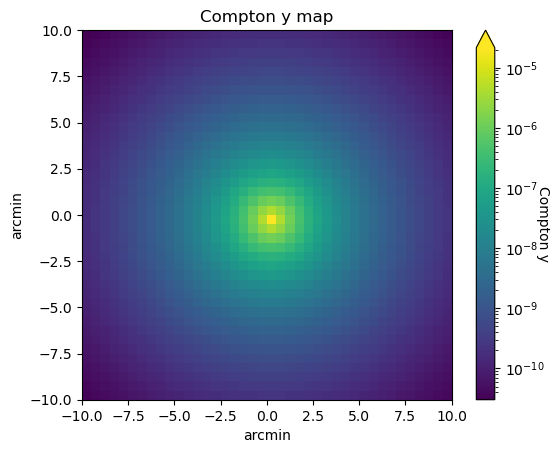

In [31]:
#This is the new function that just generates a submap without having to manually calculate params
y_map = szcluster.generate_y_submap(z, M200, R200, cosmo, 10, 0.5)
im = plt.imshow(y_map, norm=LogNorm())
cbar = plt.colorbar(im, extend="max")
im.set_extent([-width,width,-width,width])
plt.title('Compton y map')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('Compton y', rotation=270)
print("max: ", y_map.max())